# Fake News Detection with Transformer Encoder

## Library and Dataset Loading

In [1]:
import pandas as pd
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim
from sklearn.metrics import confusion_matrix

In [2]:
# Download latest version
path = kagglehub.dataset_download("aadyasingh55/fake-news-classification")

print("Path to dataset files:", path)

100%|██████████| 39.0M/39.0M [00:01<00:00, 40.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aadyasingh55/fake-news-classification/versions/1


In [3]:
train = pd.read_csv(f"{path}/train (2).csv", sep=";")
test = pd.read_csv(f"{path}/test (1).csv", sep=";")
validation = pd.read_csv(f"{path}/evaluation.csv", sep=";")

## EDA

#### Distribution of Labels

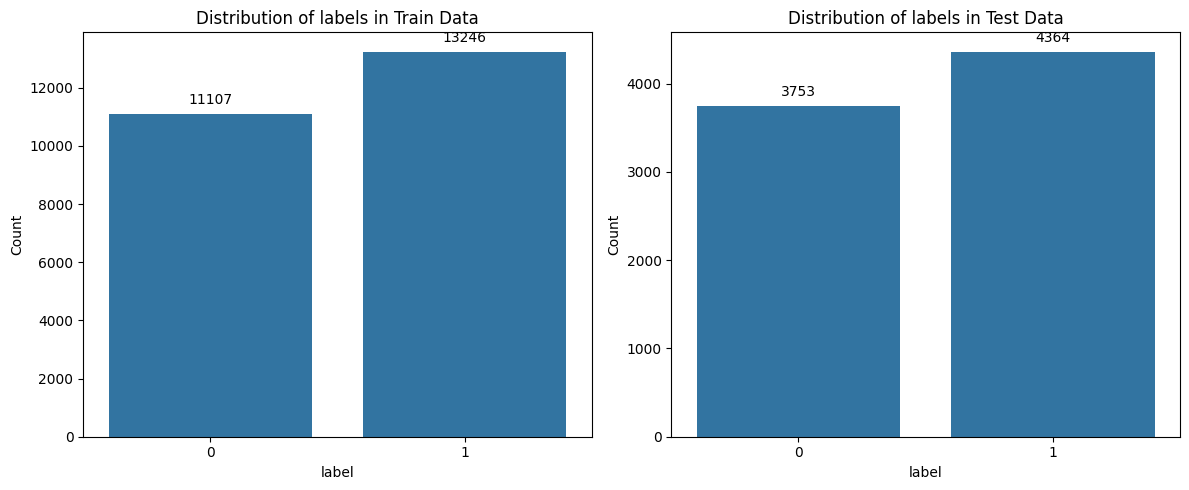

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for train data
sns.countplot(data=train, x='label', ax=axes[0])
axes[0].set_title('Distribution of labels in Train Data')
axes[0].set_xlabel('label')
axes[0].set_ylabel("Count")

# Add count annotations to train plot
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')


# Plot for test data
sns.countplot(data=test, x='label', ax=axes[1])
axes[1].set_title('Distribution of labels in Test Data')
axes[1].set_xlabel('label')
axes[1].set_ylabel("Count")

# Add count annotations to test plot
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.tight_layout()
plt.show()

#### Top 10 Words in Titles

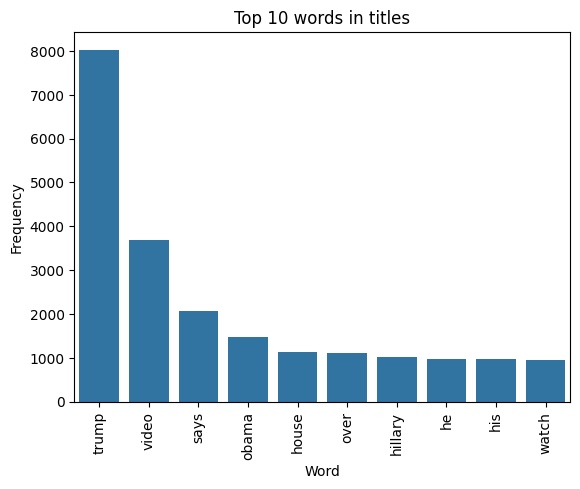

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    tokens = text.lower().split()
    stopwords = set(['the','a','and','is','to','in','s','u','of','for','with','on','after','at','as','by','from','about'])
    return [word for word in tokens if word not in stopwords]

all_words = train['title'].dropna().apply(preprocess_text).sum()
word_counts = Counter(all_words).most_common(10)

word_freq_df = pd.DataFrame(word_counts, columns=['word', 'frequency'])

sns.barplot(data=word_freq_df, x='word', y='frequency')
plt.title('Top 10 words in titles')
plt.xlabel('Word')
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

#### Top 10 Bigrams in Text

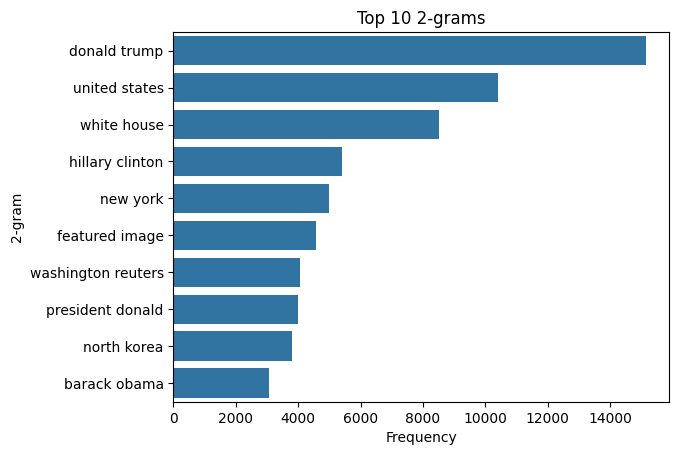

In [ ]:
# function to extract and plot top n-grams
def plot_top_ngrams(text_data, n=2, top_n=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(text_data.dropna())
    ngram_counts = pd.DataFrame(ngrams.sum(axis=0), columns=vectorizer.get_feature_names_out(), index=['count']).T
    top_ngrams = ngram_counts.nlargest(top_n, 'count')

    # plot top n-grams
    sns.barplot(data=top_ngrams.reset_index(), x='count', y='index')
    plt.title(f'Top {top_n} {n}-grams')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-gram')
    plt.show()

# plot top 2-grams for text column
plot_top_ngrams(train['text'], n=2, top_n=10)

#### Text Length Distribution by Label

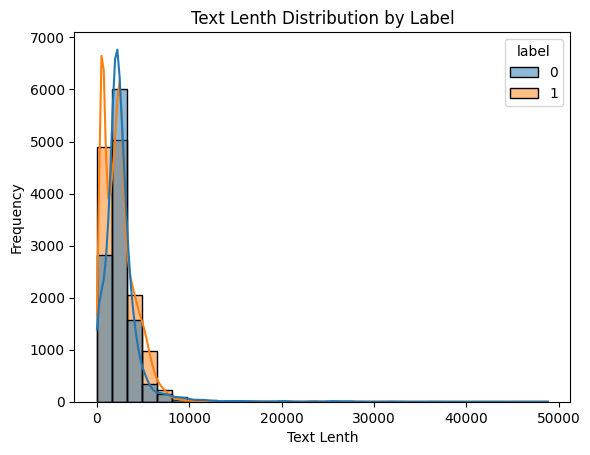

In [ ]:
train['text_length'] = train['text'].apply(lambda x : len(str(x)))

sns.histplot(data=train, x='text_length', hue = 'label', bins=30, kde=True)
plt.title("Text Lenth Distribution by Label")
plt.xlabel('Text Lenth')
plt.ylabel("Frequency")
plt.show()

#### Average TF_IDF Score by Label

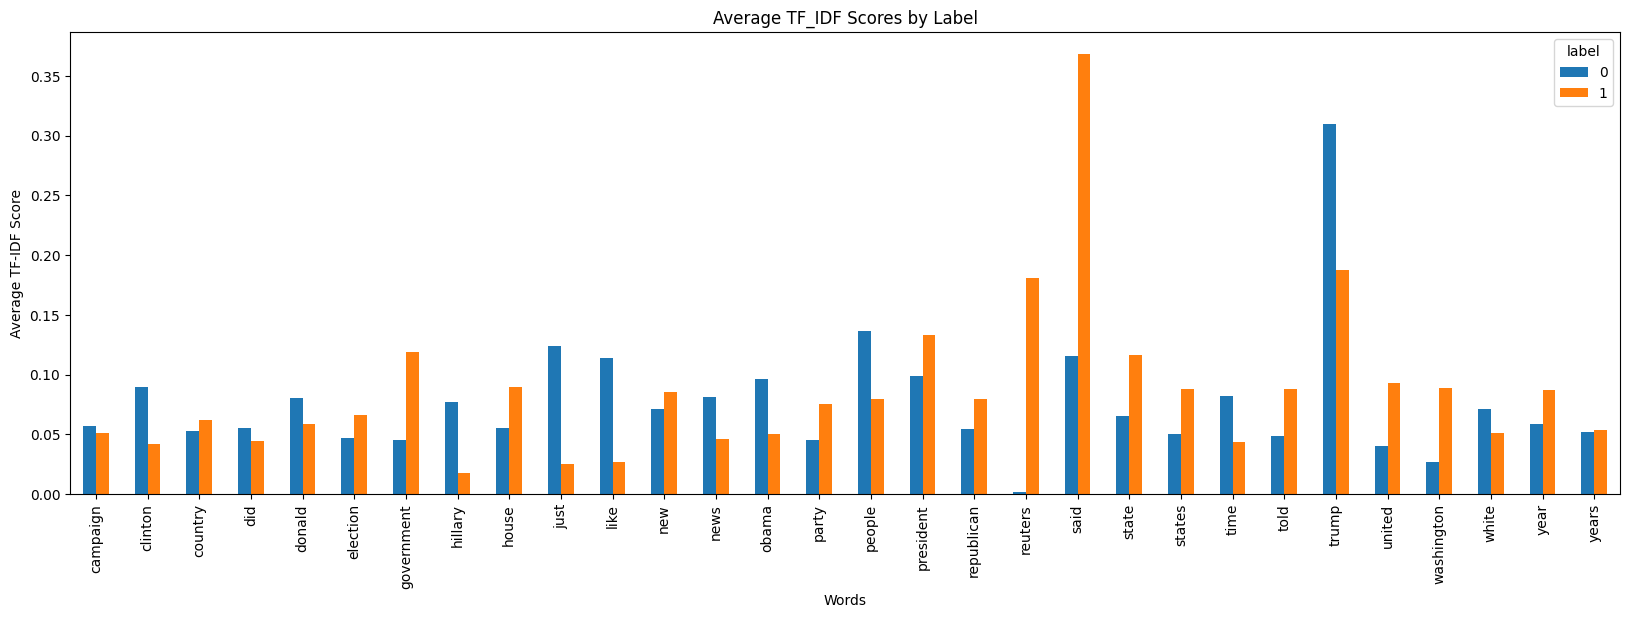

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', max_features=30)
tfidf_matrix = tfidf.fit_transform(train['text'].fillna(''))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

tfidf_df['label'] = train['label']

tfidf_avg = tfidf_df.groupby('label').mean().T

tfidf_avg.plot(kind='bar', figsize=(20,6))
plt.title('Average TF_IDF Scores by Label')
plt.ylabel('Average TF-IDF Score')
plt.xlabel('Words')
plt.show()

#### Word Cloud for Labels

In [ ]:
!pip install wordcloud

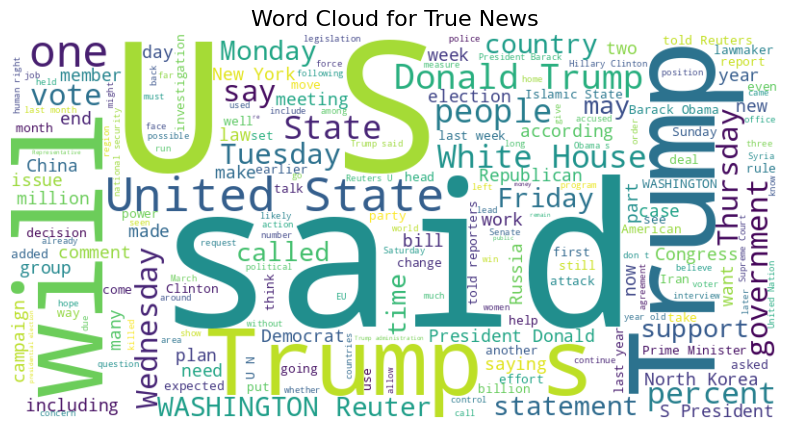

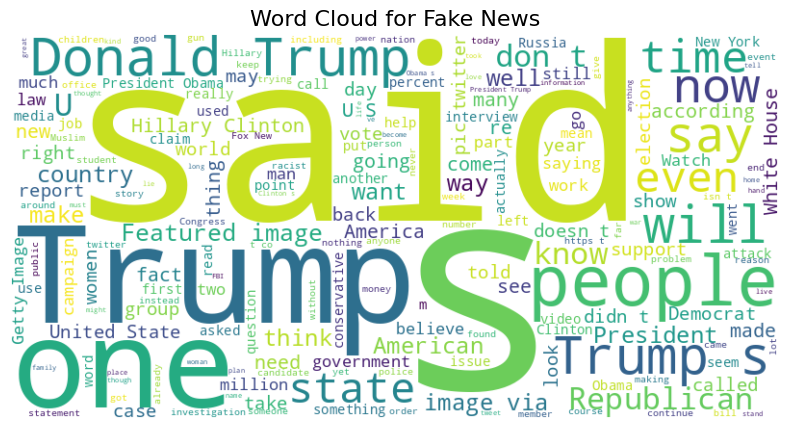

In [ ]:
from wordcloud import WordCloud

def plot_wordcloud(label):
    text = ' '.join(train[train['label'] == label]['text'].fillna('').tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    title = "Word Cloud for True News" if label == 1 else "Word Cloud for Fake News"
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

for label in train['label'].unique():
    plot_wordcloud(label)

## Data Pre-processing

In [4]:
# combining all datasets into one for easier processing
news = pd.concat([train, test, validation], ignore_index=True)

#### Delete the location and news source information at the beginning of true news otherwise the detection of source names like 'Reuters' would be a strong indicator of fake/true news.

In [5]:
# Apply the transformation to the 'text' column
def transform_text(text):
    if pd.isna(text):  # Handle missing values
      return ""
    parts = str(text).split('-', 1)
    if len(parts) > 1:
      return parts[1].strip()
    else:
      return ""

news['text'] = news['text'].apply(transform_text)

#### Drop index column and concatenate titles with texts

In [6]:
# Drop unnamed column
news = news.drop('Unnamed: 0', axis=1)

# Concatenate title and text
news['combined_text'] = news['title'] + ' ' + news['text']

#### Encoding the words

In [7]:
text_news = news['combined_text']

def clean_and_tokenize(series):
    # get rid of all punctuations
    series_cleaned = series.str.lower().apply(lambda x: re.sub(r'[^\w\s-]', '', x))
    # split words
    tokenized = series_cleaned.apply(lambda x: x.split())
    return tokenized

tokenized_news = clean_and_tokenize(text_news)

# combining all test
all_text = tokenized_news.explode().tolist()

# constructing glossary
counts = Counter(all_text)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

def encode_series(series, vocab_to_int):
    """
    对分词后的文本进行编码：
    将单词转换为对应的索引值，未登录单词映射为特殊标记 <UNK>。
    """
    vocab_to_int['<UNK>'] = len(vocab_to_int) + 1  # 添加未知词标记
    return series.apply(lambda tokens: [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in tokens])

# encoding the series
news_ints = encode_series(tokenized_news, vocab_to_int)


#### Recorded news length check

In [8]:
# outlier review stats
news_lens = Counter([len(x) for x in news_ints])
print("Zero-length news: {}".format(news_lens[0])) # review_lens[0] counts the number of reviews with zero length
print("Maximum review news: {}".format(max(news_lens)))

Zero-length news: 0
Maximum review news: 8005


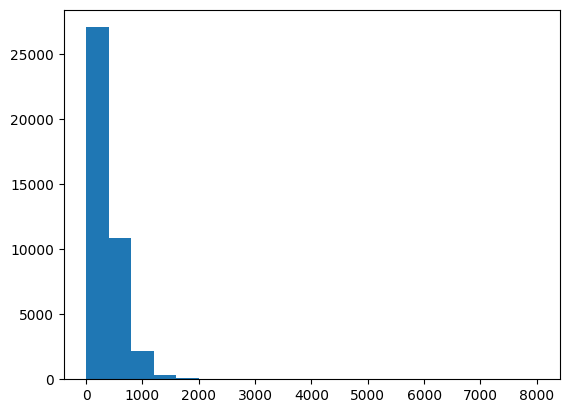

In [9]:
import matplotlib.pyplot as plt
# plot review length statistics
news_lens=[len(x) for x in news_ints]
plt.hist(news_lens,bins=20)
plt.show()

In [10]:
count = 0
for length in news_lens:
  if length > 500:
    count += 1
print(f"Count of news longer than 5000 words: {count}")

Count of news longer than 5000 words: 8433


#### It seems like none of the news recorded is empty and the majority of the news are belong 1000 wrods. Therefore, there is no need to remove outliers and we can directly get into the padding process.

#### Padding sequences

In [11]:
def pad_features(news_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's
        or truncated to the input seq_length.
    '''

    # getting the correct rows x cols shape
    features = np.zeros((len(news_ints), seq_length), dtype=int)

    # for each news, I grab that news and put it into features
    for i, row in enumerate(news_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]

    return features

In [12]:
seq_length = 500

features = pad_features(news_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(news_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches
print(features[:30,:10])

[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    4   117   187   236  1066    63     1  2225  8747  5808]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0

#### Train, Valid, Test split

In [13]:
split_frac = 0.8
labels = news['label']

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(32469, 500) 
Validation set: 	(4059, 500) 
Test set: 		(4059, 500)


#### Dataloaders and batching

In [14]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y.to_numpy()))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y.to_numpy()))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y.to_numpy()))

# dataloaders
batch_size = 32

# make sure the SHUFFLE your training data
# drop_last=True will drop the last batch if the size is less than the given batch_size
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,  drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [15]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([32, 500])
Sample input: 
 tensor([[ 117, 2880, 1925,  ...,    1, 5591,    5],
        [ 264,    2,  871,  ...,  765,  199,   10],
        [   0,    0,    0,  ...,    1,  651,  512],
        ...,
        [   0,    0,    0,  ...,  723,   31,   99],
        [   0,    0,    0,  ...,  951,   16,  338],
        [   0,    0,    0,  ...,    1,  197, 4709]])

Sample label size:  torch.Size([32])
Sample label: 
 tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1])


## Network setting and training

### Using MLP to set a benchmark for later networks

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [17]:
class MLPNetwork(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(embedding_dim * seq_length, 64) # update the input dimension to embedding_dim*seq_length
        # Output layer, 1 unit for binary classification
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Pass through the embedding layer
        x = self.embedding(x)
        # Flatten the embeddings
        x = x.view(x.shape[0], -1)
        # Cast the input tensor to float32
        x = x.type(torch.float32)  # This line ensures dtype compatibility
        # Hidden layers with ReLU activation
        x = F.relu(self.fc1(x))
        # Output layer with sigmoid activation
        x = torch.sigmoid(self.fc2(x))

        return x.squeeze()

In [18]:
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
embedding_dim = 512
mlp = MLPNetwork(vocab_size, embedding_dim).to(device) # move the model to GPU
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.0015)

epochs = 2
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    mlp.train()
    for news, labels in train_loader:
        # move news and labels to GPU
        news=news.to(device)
        labels=labels.to(device).type(torch.float32)

        outputs = mlp(news)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tot_train_loss += loss.item()

    else:
        # turn off gradients
        tot_test_loss =0
        correct = 0
        total = 0
        mlp.eval()
        with torch.no_grad():
            # validation pass here
            for news, labels in valid_loader:
              news=news.to(device)
              labels=labels.to(device).type(torch.float32)

              #forward pass
              outputs = mlp(news)
              # compute test loss
              loss = criterion(outputs, labels)
              tot_test_loss += loss.item()
              # Get the class probabilities
              predicted = (outputs >= 0.5).float().squeeze()
              # Update correct and total counts
              total += labels.size(0)
              correct += (predicted == labels).sum().item()


        train_loss = tot_train_loss /len(train_loader)
        test_loss = tot_test_loss / len(valid_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        val_acc = 100 * correct / total

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}%".format(val_acc))

Epoch: 1/2..  Training Loss: 16.673..  Test Loss: 0.184..  Test Accuracy: 91.791%
Epoch: 2/2..  Training Loss: 0.098..  Test Loss: 0.136..  Test Accuracy: 95.660%


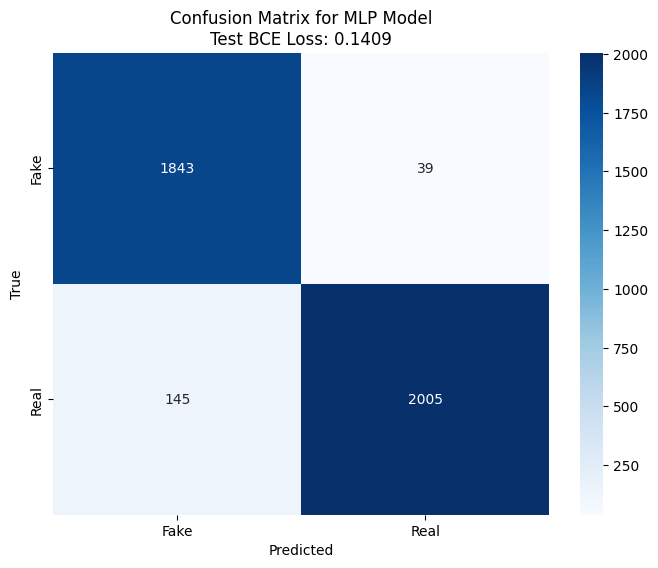

Test BCE Loss: 0.1409


In [19]:
# Initialize lists to store true labels, predicted labels, and losses
y_true = []
y_pred = []
total_loss = 0.0
criterion = nn.BCELoss()  # Define the BCE loss function

# Set the model to evaluation mode
mlp.eval()

# Iterate over the test data loader
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move data to the device
        inputs = inputs.to(device)
        labels = labels.to(device).type(torch.float32)

        # Make predictions
        outputs = mlp(inputs)
        predicted = (outputs >= 0.5).float().squeeze()

        # Calculate the loss for the batch
        loss = criterion(outputs.squeeze(), labels)
        total_loss += loss.item() * labels.size(0)  # Accumulate loss scaled by batch size

        # Append true and predicted labels to the lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute the average BCE loss over the test set
test_bce_loss = total_loss / len(test_loader.dataset)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix for MLP Model\nTest BCE Loss: {test_bce_loss:.4f}")
plt.show()

# Print the test BCE loss
print(f"Test BCE Loss: {test_bce_loss:.4f}")

### Try LSTM

#### Construct the network

In [ ]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # add embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()


    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)


        x = x.long()

        # compute embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out[:, -1, :] # getting the last time step output

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)

        # return last sigmoid output and hidden state
        return sig_out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

#### Instantiate and train the network

In [ ]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 512
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(198796, 512)
  (lstm): LSTM(512, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
def train_LSTM(net, train_loader, valid_loader, clip=5,  epochs=10):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0015)
    # Move model to GPU if available
    if (train_on_gpu):
        net.cuda()

    for e in range(epochs):
        total_loss = 0.0
        net.train()  # Set model to training mode
        # Initialize hidden state
        h = net.init_hidden(train_loader.batch_size)

        for inputs, labels in train_loader:
            if (train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()

            # Detach hidden state to prevent backprop through the entire training history
            h = tuple([each.data for each in h])

            # 1.Forward pass
            output, h = net(inputs, h)
            # 2.Compute the loss
            loss = criterion(output.squeeze(), labels.float())
            # 3.Zero accumulated gradients
            net.zero_grad()
            # 4.Backpropagation
            loss.backward()
            # Gradient clipping
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            # 5.Update weights
            optimizer.step()

            total_loss += loss.item()

        # Validation loop
        val_losses = []
        correct = 0
        total = 0
        net.eval()  # Set model to evaluation mode
        val_h = net.init_hidden(valid_loader.batch_size)

        with torch.no_grad():
            for inputs, labels in valid_loader:
                if (train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                # Detach hidden state
                val_h = tuple([each.data for each in val_h])

                # Forward pass
                output, val_h = net(inputs, val_h)

                # Compute the loss
                val_loss = criterion(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())

                # Compute accuracy
                predicted = (output.squeeze() >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print(f"Epoch: {e+1}/{epochs}...",
              f"Train Loss: {total_loss / len(train_loader):.6f}...",
              f"Val Loss: {np.mean(val_losses):.6f}...",
              f"Val Acc: {val_acc:.2f}%")

In [ ]:
# Train the model
train_LSTM(net, train_loader, valid_loader)

Epoch: 1/10... Train Loss: 0.228504... Val Loss: 0.120292... Val Acc: 95.73%
Epoch: 2/10... Train Loss: 0.095847... Val Loss: 0.116250... Val Acc: 96.21%
Epoch: 3/10... Train Loss: 0.048275... Val Loss: 0.099067... Val Acc: 96.21%
Epoch: 4/10... Train Loss: 0.030986... Val Loss: 0.116458... Val Acc: 96.35%
Epoch: 5/10... Train Loss: 0.023055... Val Loss: 0.138461... Val Acc: 96.06%
Epoch: 6/10... Train Loss: 0.017667... Val Loss: 0.139266... Val Acc: 96.43%
Epoch: 7/10... Train Loss: 0.008788... Val Loss: 0.192628... Val Acc: 96.08%
Epoch: 8/10... Train Loss: 0.007538... Val Loss: 0.201424... Val Acc: 96.40%
Epoch: 9/10... Train Loss: 0.009627... Val Loss: 0.184704... Val Acc: 95.81%
Epoch: 10/10... Train Loss: 0.009215... Val Loss: 0.184591... Val Acc: 96.08%


#### Testing the LSTM model

In [ ]:
# Evaluate the model on the test dataset
criterion = nn.BCELoss()
test_losses = [] # track loss
net.eval()
correct = 0
total = 0
y_pred = []
y_true = []

# Initialize hidden state for the test data
test_h = net.init_hidden(test_loader.batch_size)  # Assuming you have an init_hidden method in your SentimentRNN class

with torch.no_grad():
    for inputs, labels in test_loader:
        if(train_on_gpu):
          inputs, labels = inputs.cuda(), labels.cuda()

        # Detach hidden state
        test_h = tuple([each.data for each in test_h])

        # Pass the hidden state to the forward method
        outputs, test_h = net(inputs, test_h)
        outputs = outputs.squeeze()

        predicted = (outputs >= 0.5).float()

        # compute the confusion matrix
        y_pred.extend(predicted.cpu().numpy()) # move to cpu and convert to numpy array
        y_true.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = criterion(outputs, labels.float())
        test_losses.append(test_loss.item())
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test loss: 0.172
Test Accuracy: 96.25%


#### Save and load the trained LSTM model

In [ ]:
# Save the model's
torch.save(net, 'fake_news_classifier_lstm.pth')

In [ ]:
# Load the model
net = torch.load('fake_news_classifier_lstm.pth')

<ipython-input-20-425a27ba1891>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load('fake_news_classifier_lstm.pth')


#### Take a closer look at the mistakes

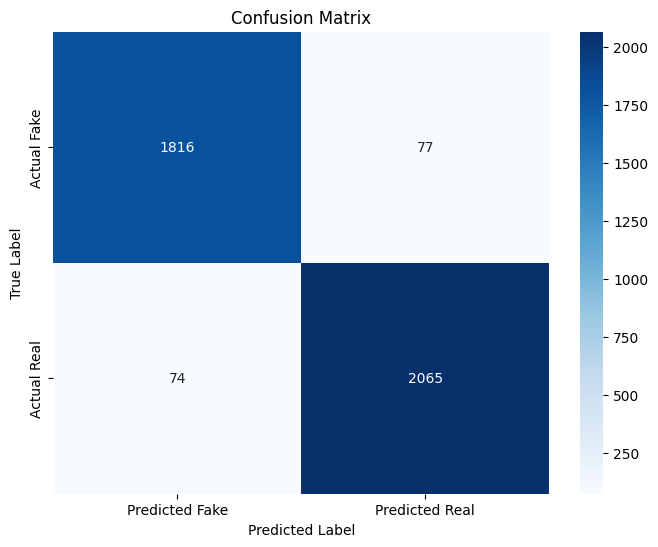

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Fake', 'Predicted Real'],
            yticklabels=['Actual Fake', 'Actual Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Function to decode an encoded sequence back into words
def decode_sequence(sequence, vocab_to_int):
    int_to_vocab = {v: k for k, v in vocab_to_int.items()}
    decoded_words = [int_to_vocab.get(word, '<UNK>') for word in sequence]  # Handle unknown words
    return ' '.join(decoded_words)

# Iterate over the test data and store misclassified examples
misclassified_examples = []

net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        test_h = net.init_hidden(inputs.size(0))
        test_h = tuple([each.data for each in test_h])
        outputs, _ = net(inputs, test_h)
        predicted = (outputs.squeeze() >= 0.5).float()

        for i in range(inputs.size(0)):
            if predicted[i] != labels[i]:
                misclassified_examples.append({
                    'text': decode_sequence(inputs[i].cpu().numpy(), vocab_to_int),
                    'true_label': labels[i].item(),
                    'predicted_label': predicted[i].item()
                })

# Print or further analyze the misclassified examples
for example in misclassified_examples:  # Print the first 20 misclassified examples
    print(f"True Label: {example['true_label']}, Predicted Label: {example['predicted_label']}")
    print(example['text'])
    print("-" * 50)

In [ ]:
for example in misclassified_examples:  # Print the first 20 misclassified examples
    print(f"True Label: {example['true_label']}, Predicted Label: {example['predicted_label']}")
    print(example['text'])
    print("-" * 50)

True Label: 1, Predicted Label: 0.0
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK

### Try Transformer Encoder for Fake News Classification

In [ ]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


#### Define embedding layer with positional encoding

In [ ]:
class ZeroEmbedding(nn.Embedding):
    """
    Used for biases.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)

In [ ]:
class PositionalEmbedding(nn.Module):
    """
    PositionalEmbedding is a class for adding positional embeddings to token embeddings.

    Args:
        sequence_length (int): The maximum sequence length.
        input_dim (int): The dimension of input token embeddings (vocabulary size)
        output_dim (int): The dimension of output positional embeddings.

    Attributes:
        token_embeddings (nn.Embedding): The token embedding layer.
        position_embeddings (nn.Embedding): The positional embedding layer.
        sequence_length (int): The maximum sequence length.
    """

    def __init__(self, sequence_length, input_dim, output_dim):
        super(PositionalEmbedding, self).__init__()
        # add embedding layers to map words to vectors
        self.token_embeddings = nn.Embedding(input_dim, output_dim)
        # add embedding layers to map position index to vectors
        self.position_embeddings = ZeroEmbedding(sequence_length, output_dim)
        self.sequence_length = sequence_length

    def forward(self, inputs):
        """
        Forward pass of the PositionalEmbedding.

        Args:
            inputs (torch.Tensor): The input tensor of token indices.

        Returns:
            torch.Tensor: The output tensor with positional embeddings added to token embeddings.
        """
        length = inputs.size(-1)
        device = inputs.device
        # compute the position index 0, 1, ..., seq_len -1
        positions = torch.arange(0, self.sequence_length).unsqueeze(0).to(device) # here we add the batch_size as first dim
        # compute the word embeddings
        embedded_tokens = self.token_embeddings(inputs)
        # compute the positional embeddings
        embedded_positions = self.position_embeddings(positions)
        # return the final embeddings
        return embedded_tokens + embedded_positions

#### Take a batch and check the embedding layer is working properly

In [ ]:
# Hyperparameters for embedding layers
vocab_size = len(vocab_to_int)+1  # +1 for the 0 padding
embed_dim = 512

In [ ]:
# Define the embedding layer with positional information
input_embed=PositionalEmbedding(seq_length, vocab_size, embed_dim)

In [ ]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
sample_x.shape, sample_y.shape

(torch.Size([32, 500]), torch.Size([32]))

In [ ]:
sample_emd=input_embed(sample_x)
sample_emd.shape

torch.Size([32, 500, 512])

#### Build transformer encoder

In [ ]:
class TransformerEncoder(nn.Module):
    """
    TransformerEncoder is a class representing a Transformer encoder block.

    Args:
        embed_dim (int): The dimension of the input embeddings and output embeddings.
        dense_dim (int): The dimension of the intermediate dense layer within the block.
        num_heads (int): The number of attention heads in the multi-head attention layer.

    Attributes:
        embed_dim (int): The dimension of the input embeddings and output embeddings.
        dense_dim (int): The dimension of the intermediate dense layer within the block.
        num_heads (int): The number of attention heads in the multi-head attention layer.
        attention (nn.MultiheadAttention): The multi-head attention layer.
        dense_proj (nn.Sequential): The sequential dense projection layers.
        layernorm_1 (nn.LayerNorm): The layer normalization after the attention layer.
        layernorm_2 (nn.LayerNorm): The layer normalization after the dense projection.
    """

    def __init__(self, embed_dim, dense_dim, num_heads):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Define multihead attention layer
        # Input and output both have size (batch_size, seq_len, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)


        # define a two-layer Feed-forward network with hidden layer size dense_dim and output layer size embed_dim
        self.dense_proj = nn.Sequential(
            nn.Linear(embed_dim, dense_dim),
            nn.ReLU(),
            nn.Linear(dense_dim, embed_dim)
        )
        # define two layer normalization layers
        self.layernorm_1 = nn.LayerNorm(embed_dim)
        self.layernorm_2 = nn.LayerNorm(embed_dim)

    def forward(self, inputs):
        """
        Forward pass of the TransformerEncoder block.

        Args:
            inputs (torch.Tensor): The input tensor of shape (batch_size, seq_len, embed_dim).

        Returns:
            torch.Tensor: The output tensor of shape ( batch_size,seq_len, embed_dim).
        """
        # pass inputs through the multihead attention layer
        attention_output, _ = self.attention(query=inputs, key=inputs, value=inputs)
        # pass the attention output through the add+normalization layer
        proj_input = self.layernorm_1(inputs + attention_output)
        # pass through the feed-forward network
        proj_output = self.dense_proj(proj_input)
        # pass through another add+normalization layer and output
        return self.layernorm_2(proj_input + proj_output)

#### Use the transformer encoder for fake news detection/classification

In [ ]:
class TransformerEncoderModel(nn.Module):
    """
    TransformerEncoderModel is a class representing a text classification model using Transformer encoder with positional embeddings.

    Args:
        vocab_size (int): The size of the vocabulary.
        embed_dim (int): The dimension of the input embeddings and output embeddings.
        num_heads (int): The number of attention heads in the Transformer encoder.
        dense_dim (int): The dimension of the intermediate dense layer.
        sequence_length (int): The maximum sequence length for positional embeddings.

    Attributes:
        embedding (PositionalEmbedding): The positional embedding layer.
        transformer_encoder (TransformerEncoder): The Transformer encoder block.
        global_max_pooling (nn.AdaptiveMaxPool1d): The global max-pooling layer.
        dropout (nn.Dropout): The dropout layer.
        fc (nn.Linear): The fully connected layer for classification.
        sigmoid (nn.Sigmoid): The sigmoid activation function for binary classification.
    """

    def __init__(self, vocab_size, embed_dim, num_heads, dense_dim, sequence_length):
        super(TransformerEncoderModel, self).__init__()

        # add embedding layer that maps word to vectors
        self.embedding = PositionalEmbedding(sequence_length, vocab_size, embed_dim)

        # add transformer encoder
        self.transformer_encoder = TransformerEncoder(embed_dim, dense_dim, num_heads)

        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(embed_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        """
        Forward pass of the TransformerEncoderModel for text classification.

        Args:
            inputs (torch.Tensor): The input tensor of shape (batch_size, seq_len).
            mask (torch.Tensor, optional): The attention mask tensor of shape (batch_size, seq_len).
                Defaults to None.

        Returns:
            torch.Tensor: The output tensor with sigmoid activation for binary classification.
        """
        x = self.embedding(inputs)
        x = self.transformer_encoder(x)        # x has shape (Batch, Seq_Len, Embed_dim)
        x,_ = torch.max(x, dim=1)              # x has shape (Batch, Embd_dim)
        x = self.dropout(x)                    # pass dropout layer
        x = self.fc(x)                         # pass a linear layer
        return self.sigmoid(x)                 # pass sigmoid activation

#### Take a batch and check the transformer model is working properly

In [ ]:
# Model
num_heads = 2
dense_dim = 1024
vocab_size = len(vocab_to_int)+1  # +1 for the 0 padding
embed_dim = 512
model = TransformerEncoderModel(vocab_size, embed_dim, num_heads, dense_dim, seq_length)
print(model)

TransformerEncoderModel(
  (embedding): PositionalEmbedding(
    (token_embeddings): Embedding(198796, 512)
    (position_embeddings): ZeroEmbedding(500, 512)
  )
  (transformer_encoder): TransformerEncoder(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (dense_proj): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
    )
    (layernorm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layernorm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
sample_output=model(sample_x)

In [ ]:
sample_x.shape, sample_y.shape

(torch.Size([32, 500]), torch.Size([32]))

In [ ]:
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_output.size()) # batch_size
print('Sample label: \n', sample_output)

Sample input size:  torch.Size([32, 500])
Sample input: 
 tensor([[     0,      0,      0,  ...,    341,   6380,    407],
        [     0,      0,      0,  ...,    594,    670, 155483],
        [     0,      0,      0,  ...,   6454,      3,    738],
        ...,
        [     0,      0,      0,  ...,   1128,    128,    572],
        [     0,      0,      0,  ...,  61084,   5560,    255],
        [  4416,   8479,    140,  ...,     24,     43,    963]])

Sample label size:  torch.Size([32, 1])
Sample label: 
 tensor([[0.5236],
        [0.5149],
        [0.7402],
        [0.3712],
        [0.7244],
        [0.2997],
        [0.2616],
        [0.3944],
        [0.6148],
        [0.6245],
        [0.6889],
        [0.7177],
        [0.6677],
        [0.7435],
        [0.5321],
        [0.5902],
        [0.6759],
        [0.4961],
        [0.5475],
        [0.4974],
        [0.4993],
        [0.3836],
        [0.4783],
        [0.7238],
        [0.4559],
        [0.5089],
        [0.6431],
 

#### Training and evaluating transformer encoder based model

In [ ]:
# move model to GPU, if available
if(train_on_gpu):
    model.cuda()

In [ ]:
def train(model, train_loader, val_loader, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.BCELoss() # since fake news detection is a binary classification task, we choose to use BCELoss as the loss function
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        ### Traing Loop ####
        #0. Loop through all the training batches
        for inputs, labels in train_loader:
            if(train_on_gpu):
              inputs,labels = inputs.cuda(), labels.cuda()

            #1. Compute the output
            outputs = model(inputs).squeeze(1)
            #2. Compute the loss
            loss = criterion(outputs, labels.float())
            #3. Zero out gradients
            optimizer.zero_grad()
            #4. Compute new gradients, by backward propagation
            loss.backward()
            #5. Update the model parameters
            optimizer.step()

            total_loss += loss.item()
        # Print training loss for this epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_loader)}")

        ### Validation Loop ###
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                if(train_on_gpu):
                  inputs, labels= inputs.cuda(), labels.cuda()
                outputs = model(inputs).squeeze(1)
                predicted = (outputs >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_acc:.2f}%")

In [ ]:
# Train the model
train(model, train_loader, valid_loader, num_epochs=6)

Epoch 1/6, Training Loss: 0.1789844254246698
Epoch 1/6, Validation Accuracy: 94.67%
Epoch 2/6, Training Loss: 0.1325750475808155
Epoch 2/6, Validation Accuracy: 94.62%
Epoch 3/6, Training Loss: 0.11355703183462663
Epoch 3/6, Validation Accuracy: 95.26%
Epoch 4/6, Training Loss: 0.09470528345640025
Epoch 4/6, Validation Accuracy: 95.71%
Epoch 5/6, Training Loss: 0.08878133107575815
Epoch 5/6, Validation Accuracy: 95.56%
Epoch 6/6, Training Loss: 0.07442388005616213
Epoch 6/6, Validation Accuracy: 95.76%


In [ ]:
# Evaluate the model on the test dataset
criterion = nn.BCELoss()
test_losses = [] # track loss
model.eval()
correct = 0
total = 0
y_pred_te = []
y_true_te = []

with torch.no_grad():
    for inputs, labels in test_loader:
        if(train_on_gpu):
          inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs).squeeze()
        predicted = (outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = criterion(outputs, labels.float())
        test_losses.append(test_loss.item())
        y_pred_te.extend(predicted.cpu().numpy()) # move to cpu and convert to numpy array
        y_true_te.extend(labels.cpu().numpy())
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test loss: 0.135
Test Accuracy: 95.93%


#### Save the current model

In [ ]:
# Save the entire model (architecture and weights)
torch.save(model, 'fake_news_classifier_transformer_encoder.pth')

#### Load the model

In [ ]:
# Load the model
model = torch.load('fake_news_classifier_transformer_encoder.pth')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

<ipython-input-37-769372e9b5e0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('fake_news_classifier_transformer_encoder.pth')


TransformerEncoderModel(
  (embedding): PositionalEmbedding(
    (token_embeddings): Embedding(198796, 512)
    (position_embeddings): ZeroEmbedding(500, 512)
  )
  (transformer_encoder): TransformerEncoder(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (dense_proj): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
    )
    (layernorm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layernorm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

#### Take a closer look at the mistakes

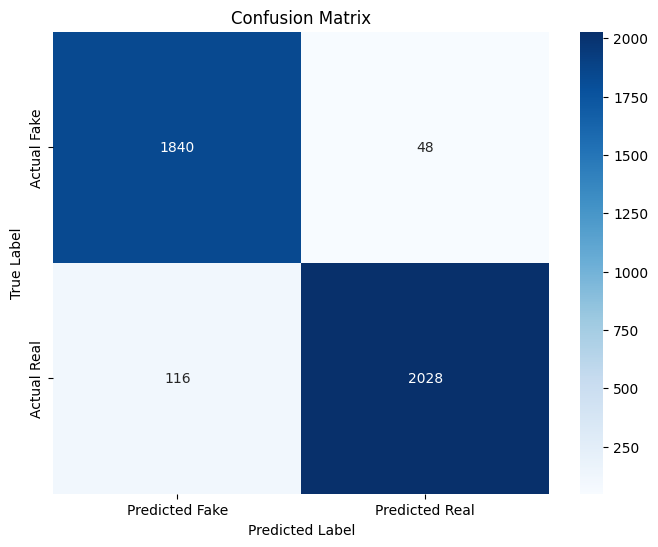

In [ ]:
# compute the confusion matrix
cm_te = confusion_matrix(y_true_te, y_pred_te)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_te, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Fake', 'Predicted Real'],
            yticklabels=['Actual Fake', 'Actual Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Iterate over the test data and store misclassified examples for the Transformer model
misclassified_transformer_examples = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs).squeeze()
        predicted = (outputs >= 0.5).float()

        for i in range(inputs.size(0)):
            if predicted[i] != labels[i]:
                misclassified_transformer_examples.append({
                    'text': decode_sequence(inputs[i].cpu().numpy(), vocab_to_int),
                    'true_label': labels[i].item(),
                    'predicted_label': predicted[i].item()
                })

# Print or further analyze the misclassified examples from the Transformer model
for example in misclassified_transformer_examples[:20]:  # Print the first 20 misclassified examples
    print(f"True Label: {example['true_label']}, Predicted Label: {example['predicted_label']}")
    print(example['text'])
    print("-" * 50)

True Label: 0, Predicted Label: 1.0
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK

#### Try the two layer model

In [ ]:
class TransformerEncoderModel(nn.Module):
    """
    TransformerEncoderModel is a class representing a text classification model using Transformer encoder with positional embeddings.

    Args:
        vocab_size (int): The size of the vocabulary.
        embed_dim (int): The dimension of the input embeddings and output embeddings.
        num_heads (int): The number of attention heads in the Transformer encoder.
        dense_dim (int): The dimension of the intermediate dense layer.
        sequence_length (int): The maximum sequence length for positional embeddings.

    Attributes:
        embedding (PositionalEmbedding): The positional embedding layer.
        transformer_encoder1 (TransformerEncoder): The first Transformer encoder block.
        transformer_encoder2 (TransformerEncoder): The second Transformer encoder block.
        global_max_pooling (nn.AdaptiveMaxPool1d): The global max-pooling layer.
        dropout (nn.Dropout): The dropout layer.
        fc (nn.Linear): The fully connected layer for classification.
        sigmoid (nn.Sigmoid): The sigmoid activation function for binary classification.
    """

    def __init__(self, vocab_size, embed_dim, num_heads, dense_dim, sequence_length):
        super(TransformerEncoderModel, self).__init__()

        # Add embedding layer that maps word to vectors
        self.embedding = PositionalEmbedding(sequence_length, vocab_size, embed_dim)

        # Add transformer encoder layers
        self.transformer_encoder1 = TransformerEncoder(embed_dim, dense_dim, num_heads)
        self.transformer_encoder2 = TransformerEncoder(embed_dim, dense_dim, num_heads)  # Additional layer

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(embed_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        """
        Forward pass of the TransformerEncoderModel for text classification.

        Args:
            inputs (torch.Tensor): The input tensor of shape (batch_size, seq_len).

        Returns:
            torch.Tensor: The output tensor with sigmoid activation for binary classification.
        """
        x = self.embedding(inputs)                      # Positional embedding
        x = self.transformer_encoder1(x)               # Pass through the first Transformer encoder
        x = self.transformer_encoder2(x)               # Pass through the second Transformer encoder
        x, _ = torch.max(x, dim=1)                     # Global max pooling
        x = self.dropout(x)                            # Apply dropout
        x = self.fc(x)                                 # Pass through the final fully connected layer
        return self.sigmoid(x)                         # Sigmoid activation for binary classification

In [ ]:
def train(model, train_loader, val_loader, num_epochs=10, save_path="best_model.pth"):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification

    best_val_acc = 0.0  # Track the best validation accuracy

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        ### Training Loop ###
        for inputs, labels in train_loader:
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            # Forward pass
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels.float())

            # Zero gradients, backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print training loss for this epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_loader):.4f}")

        ### Validation Loop ###
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs).squeeze(1)
                predicted = (outputs >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_acc:.2f}%")

        # Save the model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model, 'fake_news_classifier_transformer_encoder_2_layer.pth')  # Save the weights and the architecture
            print(f"Model improved. Saved the model with validation accuracy: {best_val_acc:.2f}%")

    print(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%.")

In [ ]:
num_heads = 2
dense_dim = 1024
vocab_size = len(vocab_to_int)+1  # +1 for the 0 padding
embed_dim = 512
model2 = TransformerEncoderModel(vocab_size, embed_dim, num_heads, dense_dim, seq_length)

In [ ]:
# move model to GPU, if available
if(train_on_gpu):
    model2.cuda()

In [ ]:
# Train the model
train(model2, train_loader, valid_loader, num_epochs=6)

Epoch 1/6, Training Loss: 0.1430
Epoch 1/6, Validation Accuracy: 95.68%
Model improved. Saved the model with validation accuracy: 95.68%
Epoch 2/6, Training Loss: 0.0722
Epoch 2/6, Validation Accuracy: 97.30%
Model improved. Saved the model with validation accuracy: 97.30%
Epoch 3/6, Training Loss: 0.0517
Epoch 3/6, Validation Accuracy: 96.23%
Epoch 4/6, Training Loss: 0.0352
Epoch 4/6, Validation Accuracy: 96.92%
Epoch 5/6, Training Loss: 0.0244
Epoch 5/6, Validation Accuracy: 96.83%
Epoch 6/6, Training Loss: 0.0159
Epoch 6/6, Validation Accuracy: 97.05%
Training completed. Best validation accuracy: 97.30%.


#### Load the best 2 layer model

In [ ]:
# Load the model
model2 = torch.load('fake_news_classifier_transformer_encoder_2_layer.pth')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

<ipython-input-25-7d44b3951f1e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2 = torch.load('fake_news_classifier_transformer_encoder_2_layer.pth')


TransformerEncoderModel(
  (embedding): PositionalEmbedding(
    (token_embeddings): Embedding(198796, 512)
    (position_embeddings): ZeroEmbedding(500, 512)
  )
  (transformer_encoder1): TransformerEncoder(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (dense_proj): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
    )
    (layernorm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layernorm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder2): TransformerEncoder(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (dense_proj): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in

#### Try 2 layer model on the test data

In [ ]:
# Evaluate the model on the test dataset
criterion = nn.BCELoss()
test_losses = [] # track loss
model2.eval()
correct = 0
total = 0
y_pred_te = []
y_true_te = []

with torch.no_grad():
    for inputs, labels in test_loader:
        if(train_on_gpu):
          inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model2(inputs).squeeze()
        predicted = (outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = criterion(outputs, labels.float())
        test_losses.append(test_loss.item())
        y_pred_te.extend(predicted.cpu().numpy()) # move to cpu and convert to numpy array
        y_true_te.extend(labels.cpu().numpy())
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test loss: 0.070
Test Accuracy: 97.37%


#### Confusion Matrix of the 2-layer model

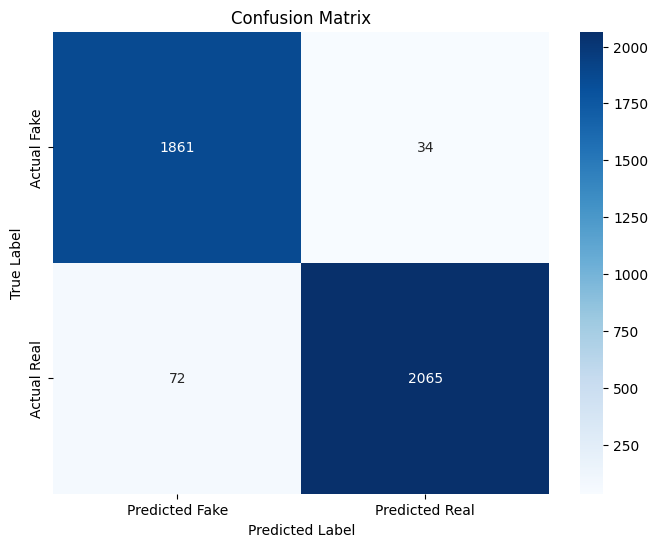

In [ ]:
# compute the confusion matrix
cm_te = confusion_matrix(y_true_te, y_pred_te)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_te, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Fake', 'Predicted Real'],
            yticklabels=['Actual Fake', 'Actual Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Inference on a test news

In [ ]:
def tokenize(test_news):
    test_news = test_news.lower() # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_news if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    test_ints.append([vocab_to_int.get(word, 0) for word in test_words])

    return test_ints

In [ ]:
def predict(net, test_review, sequence_length=500):

    net.eval()

    # tokenize review
    test_ints = tokenize(test_review)

    # pad tokenized sequence
    seq_length = sequence_length
    features = pad_features(test_ints, seq_length)

    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)

    batch_size = feature_tensor.size(0)



    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()

    # get the output from the model
    output= net(feature_tensor)

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))

    # print custom response
    if(pred.item()==1):
        print("This is a true news!")
    else:
        print("Caution, this might be a fake news!")